# Benchmarking ChargePlacer
A set of protein structures were used to benchmark the performance of ChargePlacer: PksJ ACP4 (homology model), Lysozyme (PDB:1AKI) and Transthyretin (PDB:3GRG). These input PDB files are included in the `example` folder.

*Note: While the minimisation function is deterministic (i.e. it will perform identical shuttles/shunts from a given seed sequence to the output sequence), as chargePlacer randomises the seed sequence, the exact output from this notebook will vary with each execution*

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from chargePlacer import *

In [2]:
acp4 = parse_coordinates('example/PksJACP4/ACP4_model.pdb')
lyso = parse_coordinates('example/Lysozyme/1aki.pdb')
ttr = parse_coordinates('example/TTR/3grg_cleaned.pdb')

## Defining auxillary functions for benchmarking
Functions from `chargePlacer` are imported, with two new functions defined for benchmarking purposes: `alt_minimise_energy`, which expands the standard `minimise_energy` function to output per shunt proton patterns, and `benchmark_run`, which wraps around the minimisation function and runs it a specified number of times.

In [3]:
def alt_minimise_energy(deprot_charges, affinities, xyz, charge, coulomb_only=False, verbose=False):
    """An altered version of the standard chargePlacer Minimising function.
    Additionally returns the best proton pattern for each shunt. Extra verbose output supressed.
    Iterates through a proton sequence to find the combination that provides the miminal energy.

    Parameters
    ----------
    deprot_charges : ndarray
        charge of residue when deprotonated (1xN array)
    affinities : ndarray
        proton affinities of each residue (1xN array)
    xyz : ndarray
        coordinates for point charges (Nx3)
    charge : int
        target charge state
    coulomb_only : bool
        whether to only calculate Coulomb energy
    verbose : bool
        whether to print results

    Returns
    -------
    proton_seq : ndarray
        current best proton sequence after minimisation
    e_total : float
        total energy of `proton_seq` after minimisation (Only if `coulomb_only`=False)
    e_coulomb : float
            Coulomb energy of `proton_seq` after minimisation
    e_proton : float
            binding energy of `proton_seq` after minimisation
    """
    # Initialise local variables
    proton_seq = moveable_protons(deprot_charges, charge)
    mask = np.mask_indices(len(proton_seq), np.triu, 1)
    distances = distance_matrix(xyz, xyz)[mask]

    if coulomb_only:
        get_energy = lambda: coulomb_energy(proton_seq + deprot_charges, distances, mask)
    else:
        get_energy = lambda: (coulomb_energy(proton_seq + deprot_charges, distances, mask)
                              - binding_energy(proton_seq, affinities))

    # Initial energies
    current_min = get_energy()
    shunt_min = current_min
    counters = [time.process_time(), 0, 0]
    shunts = [proton_seq.copy()]

    while shunt_min <= current_min:
        counters[1] += 1
        shunt_min = get_energy()
        best_shunt = [0, 0]
        deprot_sequence = np.where(proton_seq == 0)[0]

        for p in proton_seq.nonzero()[0]:
            proton_seq[p] = 0
            # For all protonatable sites
            for d in deprot_sequence:
                counters[2] += 1
                proton_seq[d] = 1
                e_tot = get_energy()
                if e_tot <= shunt_min:
                    shunt_min = e_tot
                    best_shunt = [p, d]
                proton_seq[d] = 0
            proton_seq[p] = 1
        # Update `proton_seq` to best values
        if shunt_min >= current_min:
            e_coulomb = coulomb_energy(proton_seq+deprot_charges, distances, mask)
            e_proton = binding_energy(proton_seq, affinities)
            counters[0] = time.process_time() - counters[0]
            break
        # Reset `proton_seq` to best sequence to reseed
        proton_seq[best_shunt[0]] = 0
        proton_seq[best_shunt[1]] = 1
        current_min = shunt_min
        shunts.append(proton_seq.copy())

    return proton_seq, current_min, e_coulomb, e_proton, counters, shunts

In [4]:
def benchmark_run(name, repeats, coords, charge_state, coulomb_only=False):
    num_sites = len(coords[1])
    num_protons = charge_state - coords[1].sum()
    benchmarks = {'opt_seq' : np.zeros((repeats, num_sites), dtype='int'), 'seed_seq' : np.zeros((repeats, num_sites), dtype='int'), 
                  'ecoulomb' : np.zeros(repeats), 'eproton' : np.zeros(repeats), 'num_shunts' : np.zeros(repeats, dtype='int'), 
                  'num_steps' : np.zeros(repeats, dtype='int'), 'num_protons' : num_protons, 'num_sites' : num_sites, 
                  'num_repeats' : repeats, 'coulomb_only' : coulomb_only, 'name' : name, 'residues' : coords[0]}
    for i in range(repeats):
        rep = alt_minimise_energy(coords[1], coords[2], coords[3], charge_state, coulomb_only=coulomb_only)
        benchmarks['opt_seq'][i] = rep[0]
        benchmarks['seed_seq'][i] = rep[5][0]
        benchmarks['ecoulomb'][i] = rep[2]
        benchmarks['eproton'][i] = rep[3]
        benchmarks['num_shunts'][i] = rep[4][1]
        benchmarks['num_steps'][i] = rep[4][2]
    print('{} repeats of {} {}+ performed successfully'.format(repeats, name, charge_state))
    
    unique_patterns = np.unique(benchmarks['opt_seq'], axis=0, return_index=True, return_counts=True)
    print('There were {} unique proton patterns:'.format(unique_patterns[2].shape[0]))
    for p, count in enumerate(unique_patterns[2]):
        print('\nPattern {} occurred {} times'.format(p+1, count))
        idx = unique_patterns[1][p]
        print('Coulomb = {:.2f} kJ/mol, PA = {:.1f} kJ/mol'.format(benchmarks['ecoulomb'][idx], benchmarks['eproton'][idx]))
        print(unique_patterns[0][p])
    return benchmarks

## PksJ ACP4 with 100 Replicates
The `benchmark_run` function is used on the ACP4 PDB file for the 8+ charge state in both Coulomb-only and Coulomb-PA modes. This is performed for 100 replicates, the outputs for which are collated and displayed in textual and graphical form.

In [5]:
acp4_coul_repeats = benchmark_run('ACP4', 100, acp4, 8, coulomb_only=True)

100 repeats of ACP4 8+ performed successfully
There were 2 unique proton patterns:

Pattern 1 occurred 34 times
Coulomb = -1029.51 kJ/mol, PA = 34496.0 kJ/mol
[0 1 1 1 0 1 0 1 1 1 1 1 1 0 0 0 0 0 1 1 1 0 1 1 1 1 1 1 1 1 0 1 1 1 0 1 1
 1 1 1]

Pattern 2 occurred 66 times
Coulomb = -1035.06 kJ/mol, PA = 34424.6 kJ/mol
[1 0 1 1 0 0 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 0 1 1 1 1 1 1 1 1 0 1 1 1 0 1 1
 1 1 1]


Text(0.5, 1, 'ACP4$^{8+}$ Coulomb-Only, 100 replicates')

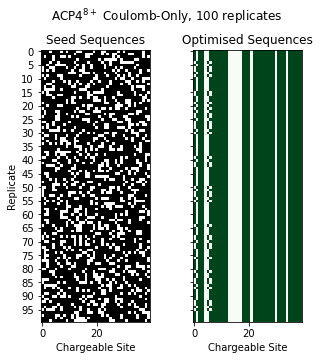

In [6]:
fig, ax = plt.subplots(1,2, figsize=(5,5),sharey=True)
ax[0].imshow(acp4_coul_repeats['seed_seq'], cmap='Greys', interpolation='nearest')
ax[0].set_yticks(range(0, acp4_coul_repeats['num_repeats'], 5))
ax[0].set_ylabel('Replicate')
ax[0].set_xlabel('Chargeable Site')
ax[0].set_title('Seed Sequences')
ax[1].imshow(acp4_coul_repeats['opt_seq'], cmap='Greens', interpolation='nearest')
ax[1].set_xlabel('Chargeable Site')
ax[1].set_title('Optimised Sequences')
fig.suptitle(r'ACP4$^{8+}$ Coulomb-Only, 100 replicates', y=1)

In [7]:
acp4_tot_repeats = benchmark_run('ACP4', 100, acp4, 8, coulomb_only=False)

100 repeats of ACP4 8+ performed successfully
There were 1 unique proton patterns:

Pattern 1 occurred 100 times
Coulomb = 657.25 kJ/mol, PA = 37401.0 kJ/mol
[0 0 0 1 0 0 0 1 1 1 1 1 1 0 0 1 1 1 1 1 0 1 1 1 1 1 1 0 1 0 1 1 1 1 1 1 1
 1 1 1]


Text(0.5, 1, 'ACP4$^{8+}$ Coulomb-PA, 100 replicates')

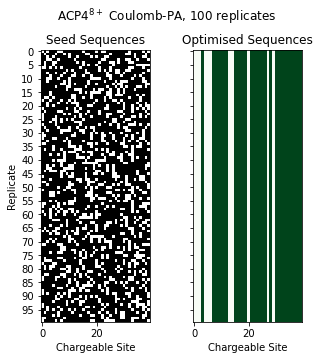

In [8]:
fig, ax = plt.subplots(1,2, figsize=(5,5),sharey=True)
ax[0].imshow(acp4_tot_repeats['seed_seq'], cmap='Greys', interpolation='nearest')
ax[0].set_yticks(range(0, acp4_tot_repeats['num_repeats'], 5))
ax[0].set_ylabel('Replicate')
ax[0].set_xlabel('Chargeable Site')
ax[0].set_title('Seed Sequences')
ax[1].imshow(acp4_tot_repeats['opt_seq'], cmap='Greens', interpolation='nearest')
ax[1].set_xlabel('Chargeable Site')
ax[1].set_title('Optimised Sequences')
fig.suptitle(r'ACP4$^{8+}$ Coulomb-PA, 100 replicates', y=1)

Text(0.5, 0.98, 'ACP4$^{8+}$ Charge Distribution, 100 replicates')

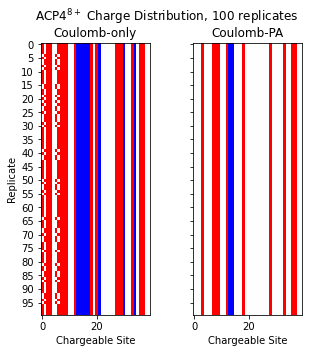

In [9]:
fig, ax = plt.subplots(1,2, figsize=(5,5),sharey=True)
ax[0].imshow(acp4_coul_repeats['opt_seq'] + acp4[1], cmap='bwr', interpolation='nearest')
ax[0].set_yticks(range(0, acp4_coul_repeats['num_repeats'], 5))
ax[0].set_ylabel('Replicate')
ax[0].set_xlabel('Chargeable Site')
ax[0].set_title('Coulomb-only')
ax[1].imshow(acp4_tot_repeats['opt_seq'] + acp4[1], cmap='bwr', interpolation='nearest')
ax[1].set_xlabel('Chargeable Site')
ax[1].set_title('Coulomb-PA')
fig.suptitle(r'ACP4$^{8+}$ Charge Distribution, 100 replicates', y=0.98)

319 steps/shunt
Coulomb-only took 8.81 ± 1.29 shunts to optimise
Coulomb-PA took 9.78 ± 1.62 shunts to optimise


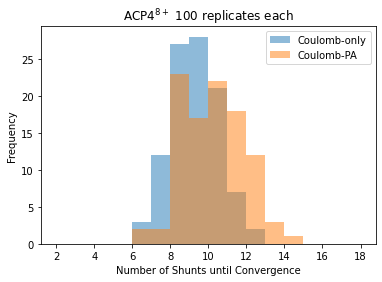

In [10]:
bins = range(2,19,1)
plt.hist(acp4_coul_repeats['num_shunts'], bins=bins, alpha=0.5, label='Coulomb-only')
plt.hist(acp4_tot_repeats['num_shunts'], bins=bins, alpha=0.5, label='Coulomb-PA')
plt.ylabel('Frequency')
plt.xlabel('Number of Shunts until Convergence')
plt.title(r'ACP4$^{8+}$ 100 replicates each')
plt.legend()
print('{} steps/shunt'.format((acp4_coul_repeats['num_sites']-acp4_coul_repeats['num_protons'])*acp4_coul_repeats['num_protons']))
print('Coulomb-only took {:.2f} ± {:.2f} shunts to optimise'.format(acp4_coul_repeats['num_shunts'].mean(), acp4_coul_repeats['num_shunts'].std()))
print('Coulomb-PA took {:.2f} ± {:.2f} shunts to optimise'.format(acp4_tot_repeats['num_shunts'].mean(), acp4_tot_repeats['num_shunts'].std()))

## Lysozyme with 100 Replicates
The `benchmark_run` function is used on the lysozyme PDB file for the 8+ charge state in both Coulomb-only and Coulomb-PA modes. This is performed for 100 replicates, the outputs for which are collated and displayed in textual and graphical form.

In [12]:
lyso_coul_repeats = benchmark_run('Lysozyme', 100, lyso, 8, coulomb_only=True)

100 repeats of Lysozyme 8+ performed successfully
There were 1 unique proton patterns:

Pattern 1 occurred 100 times
Coulomb = -961.27 kJ/mol, PA = 17908.1 kJ/mol
[1 1 1 0 1 1 1 0 1 1 0 0 0 1 1 0 1 1 0 0 1 0 1 1 1 0 1 1 0]


Text(0.5, 1, 'Lysozyme$^{8+}$ Coulomb-Only, 100 replicates')

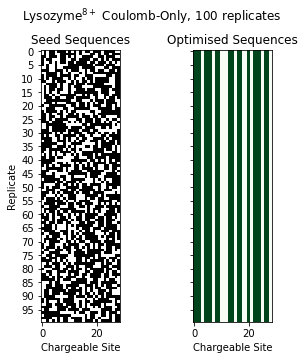

In [13]:
fig, ax = plt.subplots(1,2, figsize=(5,5),sharey=True)
ax[0].imshow(lyso_coul_repeats['seed_seq'], cmap='Greys', interpolation='nearest')
ax[0].set_yticks(range(0, lyso_coul_repeats['num_repeats'], 5))
ax[0].set_ylabel('Replicate')
ax[0].set_xlabel('Chargeable Site')
ax[0].set_title('Seed Sequences')
ax[1].imshow(lyso_coul_repeats['opt_seq'], cmap='Greens', interpolation='nearest')
ax[1].set_xlabel('Chargeable Site')
ax[1].set_title('Optimised Sequences')
fig.suptitle(r'Lysozyme$^{8+}$ Coulomb-Only, 100 replicates', y=1)

In [14]:
lyso_tot_repeats = benchmark_run('Lysozyme', 100, lyso, 8, coulomb_only=False)

100 repeats of Lysozyme 8+ performed successfully
There were 1 unique proton patterns:

Pattern 1 occurred 100 times
Coulomb = 1583.48 kJ/mol, PA = 22517.5 kJ/mol
[0 0 0 1 0 1 0 1 1 0 1 1 1 1 0 1 0 1 1 0 0 1 1 1 0 1 1 1 1]


Text(0.5, 1, 'Lysozyme$^{8+}$ Coulomb-PA, 100 replicates')

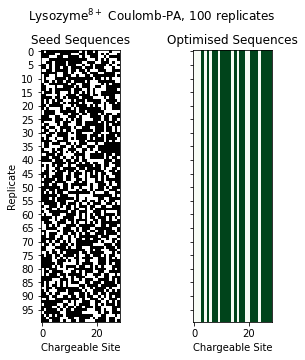

In [15]:
fig, ax = plt.subplots(1,2, figsize=(5,5),sharey=True)
ax[0].imshow(lyso_tot_repeats['seed_seq'], cmap='Greys', interpolation='nearest')
ax[0].set_yticks(range(0, lyso_tot_repeats['num_repeats'], 5))
ax[0].set_ylabel('Replicate')
ax[0].set_xlabel('Chargeable Site')
ax[0].set_title('Seed Sequences')
ax[1].imshow(lyso_tot_repeats['opt_seq'], cmap='Greens', interpolation='nearest')
ax[1].set_xlabel('Chargeable Site')
ax[1].set_title('Optimised Sequences')
fig.suptitle(r'Lysozyme$^{8+}$ Coulomb-PA, 100 replicates', y=1)

Text(0.5, 1, 'Lysozyme$^{8+}$ Charge Distribution, 100 replicates')

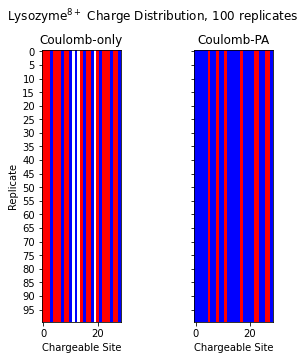

In [16]:
fig, ax = plt.subplots(1,2, figsize=(5,5),sharey=True)
ax[0].imshow(lyso_coul_repeats['opt_seq'] + lyso[1], cmap='bwr', interpolation='nearest')
ax[0].set_yticks(range(0, lyso_coul_repeats['num_repeats'], 5))
ax[0].set_ylabel('Replicate')
ax[0].set_xlabel('Chargeable Site')
ax[0].set_title('Coulomb-only')
ax[1].imshow(lyso_tot_repeats['opt_seq'] + lyso[1], cmap='bwr', interpolation='nearest')
ax[1].set_xlabel('Chargeable Site')
ax[1].set_title('Coulomb-PA')
fig.suptitle(r'Lysozyme$^{8+}$ Charge Distribution, 100 replicates', y=1)

198 steps/shunt
Coulomb-only took 8.46 ± 1.49 shunts to optimise
Coulomb-PA took 8.31 ± 1.32 shunts to optimise


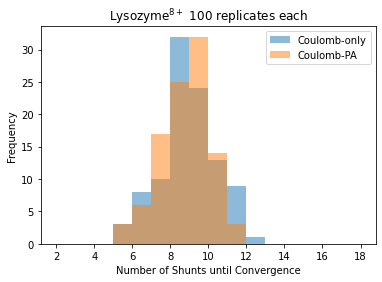

In [35]:
bins = range(2,19,1)
plt.hist(lyso_coul_repeats['num_shunts'], bins=bins, alpha=0.5, label='Coulomb-only')
plt.hist(lyso_tot_repeats['num_shunts'], bins=bins, alpha=0.5, label='Coulomb-PA')
plt.ylabel('Frequency')
plt.xlabel('Number of Shunts until Convergence')
plt.title(r'Lysozyme$^{8+}$ 100 replicates each')
plt.legend()
print('{} steps/shunt'.format((lyso_coul_repeats['num_sites']-lyso_coul_repeats['num_protons'])*lyso_coul_repeats['num_protons']))
print('Coulomb-only took {:.2f} ± {:.2f} shunts to optimise'.format(lyso_coul_repeats['num_shunts'].mean(), lyso_coul_repeats['num_shunts'].std()))
print('Coulomb-PA took {:.2f} ± {:.2f} shunts to optimise'.format(lyso_tot_repeats['num_shunts'].mean(), lyso_tot_repeats['num_shunts'].std()))

## TTR with 10 Replicates
The `benchmark_run` function is used on the TTR PDB file for the 14+ charge state in both Coulomb-only and Coulomb-PA modes. This is performed for 10 replicates, the outputs for which are collated and displayed in textual and graphical form. Due to the increased number of chargeable sites, this takes much longer (ca. 110,000 steps) than ACP4 (ca. 3,000 steps) or lysozyme (ca. 1,500 steps).

In [18]:
ttr_coul_repeats = benchmark_run('TTR', 10, ttr, 14, coulomb_only=True)

10 repeats of TTR 14+ performed successfully
There were 1 unique proton patterns:

Pattern 1 occurred 10 times
Coulomb = -10054.71 kJ/mol, PA = 84685.7 kJ/mol
[0 1 0 1 1 1 1 1 0 0 1 0 0 1 1 1 1 1 1 0 0 1 1 1 0 1 0 0 1 1 0 1 1 0 1 1 1
 1 1 0 1 1 0 0 1 0 1 1 1 1 0 0 1 1 1 0 1 0 0 1 1 0 1 1 0 1 1 1 1 1 0 1 1 0
 0 1 0 1 1 1 1 0 0 1 1 1 0 1 0 0 1 1 0 0 1 0 1 1 1 1 1 0 0 1 1 0 1 1 1 1 1
 1 0 0 1 0 1 0 1 0 0 1 1 0]


Text(0.5, 1, 'TTR$^{14+}$ Coulomb-Only, 10 replicates')

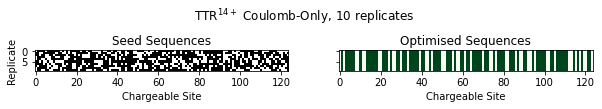

In [19]:
fig, ax = plt.subplots(1,2, figsize=(10,1.5),sharey=True)
ax[0].imshow(ttr_coul_repeats['seed_seq'], cmap='Greys', interpolation='nearest')
ax[0].set_yticks(range(0, ttr_coul_repeats['num_repeats'], 5))
ax[0].set_ylabel('Replicate')
ax[0].set_xlabel('Chargeable Site')
ax[0].set_title('Seed Sequences')
ax[1].imshow(ttr_coul_repeats['opt_seq'], cmap='Greens', interpolation='nearest')
ax[1].set_xlabel('Chargeable Site')
ax[1].set_title('Optimised Sequences')
fig.suptitle(r'TTR$^{14+}$ Coulomb-Only, 10 replicates', y=1)

In [20]:
ttr_tot_repeats = benchmark_run('TTR', 10, ttr, 14, coulomb_only=False)

10 repeats of TTR 14+ performed successfully
There were 2 unique proton patterns:

Pattern 1 occurred 4 times
Coulomb = 602.19 kJ/mol, PA = 103781.5 kJ/mol
[0 0 0 1 0 1 0 1 1 1 1 1 1 0 1 1 1 1 0 1 1 0 0 0 1 0 1 1 1 1 1 0 0 0 1 0 1
 0 1 1 1 0 1 1 0 1 1 1 1 0 1 1 0 0 0 1 0 1 1 1 1 1 0 0 0 1 0 1 0 1 1 1 1 1
 1 0 1 1 1 1 0 1 1 0 0 0 1 0 1 1 1 1 0 0 0 0 1 0 1 0 1 1 1 0 1 1 0 1 1 1 1
 1 0 1 0 0 0 1 1 1 1 1 1 1]

Pattern 2 occurred 6 times
Coulomb = 1070.16 kJ/mol, PA = 104268.0 kJ/mol
[0 0 0 1 0 1 0 1 1 1 1 1 1 0 1 1 1 1 0 1 1 0 0 0 1 0 1 1 1 1 1 0 0 0 1 0 1
 0 1 1 1 0 1 1 1 1 1 1 1 0 1 1 0 0 0 1 0 1 1 1 0 1 0 0 0 1 1 1 0 1 1 1 0 1
 1 0 1 1 1 1 0 1 1 0 0 0 1 0 1 1 1 1 0 0 0 0 1 0 1 0 1 1 1 1 1 1 0 1 1 1 1
 0 1 1 0 0 0 1 0 1 1 1 1 1]


Text(0.5, 1, 'TTR$^{14+}$ Coulomb-PA, 10 replicates')

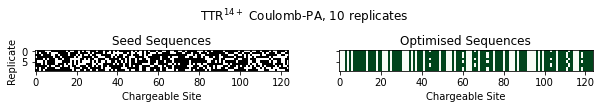

In [21]:
fig, ax = plt.subplots(1,2, figsize=(10,1.5),sharey=True)
ax[0].imshow(ttr_tot_repeats['seed_seq'], cmap='Greys', interpolation='nearest')
ax[0].set_yticks(range(0, ttr_tot_repeats['num_repeats'], 5))
ax[0].set_ylabel('Replicate')
ax[0].set_xlabel('Chargeable Site')
ax[0].set_title('Seed Sequences')
ax[1].imshow(ttr_tot_repeats['opt_seq'], cmap='Greens', interpolation='nearest')
ax[1].set_xlabel('Chargeable Site')
ax[1].set_title('Optimised Sequences')
fig.suptitle(r'TTR$^{14+}$ Coulomb-PA, 10 replicates', y=1)

Text(0.5, 1, 'TTR$^{14+}$ Charge Distribution, 10 replicates')

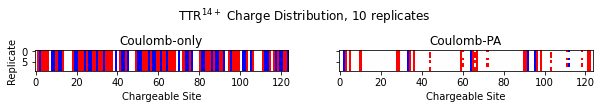

In [22]:
fig, ax = plt.subplots(1,2, figsize=(10,1.5),sharey=True)
ax[0].imshow(ttr_coul_repeats['opt_seq'] + ttr[1], cmap='bwr', interpolation='nearest')
ax[0].set_yticks(range(0, ttr_coul_repeats['num_repeats'], 5))
ax[0].set_ylabel('Replicate')
ax[0].set_xlabel('Chargeable Site')
ax[0].set_title('Coulomb-only')
ax[1].imshow(ttr_tot_repeats['opt_seq'] + ttr[1], cmap='bwr', interpolation='nearest')
ax[1].set_xlabel('Chargeable Site')
ax[1].set_title('Coulomb-PA')
fig.suptitle(r'TTR$^{14+}$ Charge Distribution, 10 replicates', y=1)

3588 steps/shunt
Coulomb-only took 30.20 ± 3.09 shunts to optimise
Coulomb-PA took 31.40 ± 2.58 shunts to optimise


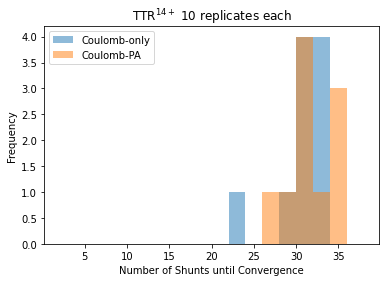

In [37]:
bins = range(2,40,2)
plt.hist(ttr_coul_repeats['num_shunts'], bins=bins, alpha=0.5, label='Coulomb-only')
plt.hist(ttr_tot_repeats['num_shunts'], bins=bins, alpha=0.5, label='Coulomb-PA')
plt.ylabel('Frequency')
plt.xlabel('Number of Shunts until Convergence')
plt.title(r'TTR$^{14+}$ 10 replicates each')
plt.legend()
print('{} steps/shunt'.format((ttr_coul_repeats['num_sites']-ttr_coul_repeats['num_protons'])*ttr_coul_repeats['num_protons']))
print('Coulomb-only took {:.2f} ± {:.2f} shunts to optimise'.format(ttr_coul_repeats['num_shunts'].mean(), ttr_coul_repeats['num_shunts'].std()))
print('Coulomb-PA took {:.2f} ± {:.2f} shunts to optimise'.format(ttr_tot_repeats['num_shunts'].mean(), ttr_tot_repeats['num_shunts'].std()))